In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# --- Các mô hình cần so sánh ---
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

DATA_PATH = "filled_dataset1.csv"

# --- Load ---
df = pd.read_csv(DATA_PATH)
# Xóa cột Co2_Capita_tCO2
if 'Co2_Capita_tCO2' in df.columns:
    df = df.drop(columns=['Co2_Capita_tCO2'])
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Đặt output là Co2_MtCO2
target_col = 'Co2_MtCO2'
y = df[target_col]
# Remove the 'Year' column from the features
X = df.drop(columns=[target_col, 'Year'])

Shape: (4180, 19)
Columns: ['Country', 'ISO_Code', 'Year', 'Co2_MtCO2', 'GDP', 'Population', 'Industry_on_GDP', 'HDI', 'Government_Expenditure_on_Education', 'Global_Climate_Risk_Index', 'Area_ha', 'Forest_Area_ha', 'Forest_Area_Percent', 'Deforest_Area_ha', 'Deforest_Percent', 'Energy_Capita_kWh', 'Energy_MWh', 'Renewable_Energy_MWh', 'Renewable_Energy_Percent']


In [ ]:
# --- 2. Xử lý dữ liệu ---
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, cat_cols)
])

# --- 3. Chia tập train/test ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# --- 4. Định nghĩa danh sách mô hình ---
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01, max_iter=10000),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVR (RBF)": SVR(kernel='rbf', C=10, epsilon=0.1)
}

In [ ]:
# --- 5. Huấn luyện và đánh giá ---
results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    })

In [ ]:
# --- 6. Hiển thị kết quả ---
results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
print("🔍 Kết quả so sánh các mô hình dự đoán CO₂:\n")
print(results_df)

🔍 Kết quả so sánh các mô hình dự đoán CO₂:

               Model           RMSE        MAE        R²
3      Random Forest     759.031415   6.211225  0.998199
5            XGBoost    1171.678485   7.608513  0.997220
4  Gradient Boosting    1347.560428  14.581858  0.996802
6                KNN    1384.880640   8.328393  0.996714
0  Linear Regression    3610.595004  26.180342  0.991433
2              Lasso    3904.058533  25.085745  0.990736
1              Ridge    4319.412781  24.270681  0.989751
7          SVR (RBF)  390167.907259  74.515719  0.074195


In [ ]:
# --- 7. Lưu mô hình tốt nhất ---
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model)
])
final_pipeline.fit(X, y)

import joblib
model_path = f"best_CO2_model_{best_model_name.replace(' ', '_')}.pkl"
joblib.dump(final_pipeline, model_path)
print(f"\nMô hình tốt nhất: {best_model_name}")
print(f"Đã lưu tại: {model_path}")


Mô hình tốt nhất: Random Forest
Đã lưu tại: best_CO2_model_Random_Forest.pkl


In [ ]:
import pandas as pd
import joblib

# Load model đã huấn luyện
model = joblib.load("best_CO2_model_Random_Forest.pkl")

# Load lại dataset gốc
df = pd.read_csv("filled_dataset1.csv")

# Xóa cột không cần
if 'Co2_Capita_tCO2' in df.columns:
    df = df.drop(columns=['Co2_Capita_tCO2'])

# Chọn năm 2020
df_2020 = df[df['Year'] == 2020].copy()

# Giữ lại features và target thật
target_col = 'Co2_MtCO2'
X_2020 = df_2020.drop(columns=[target_col])
y_true_2020 = df_2020[target_col]

# Dự đoán
y_pred_2020 = model.predict(X_2020)

# So sánh kết quả
results = pd.DataFrame({
    "Country": df_2020["Country"],
    "Year": df_2020["Year"],
    "Actual_CO2": y_true_2020,
    "Predicted_CO2": y_pred_2020,
    "Error": y_true_2020 - y_pred_2020
})

print("So sánh kết quả thực tế và dự đoán năm 2020:")
print(results.head(10))  # hiển thị 10 quốc gia đầu tiên


So sánh kết quả thực tế và dự đoán năm 2020:
                 Country  Year  Actual_CO2  Predicted_CO2     Error
19           Afghanistan  2020      11.606      11.294660  0.311340
41               Albania  2020       4.711       4.819725 -0.108725
63               Algeria  2020     168.178     164.353435  3.824565
85               Andorra  2020       0.381       0.425495 -0.044495
107               Angola  2020      16.533      17.147270 -0.614270
129  Antigua and Barbuda  2020       0.619       0.613525  0.005475
151            Argentina  2020     165.121     170.492140 -5.371140
173              Armenia  2020       6.795       6.785035  0.009965
195            Australia  2020     399.184     400.738535 -1.554535
217              Austria  2020      62.176      63.898235 -1.722235


In [ ]:
import pandas as pd
import joblib

# Load model
model = joblib.load("best_CO2_model_Random_Forest.pkl")

# Tạo input năm 2020
input_data = {
    'Country': ['Viet Nam'],
    'ISO_Code': ['VNM'],
    'Year': [2020],
    'GDP': [342000],
    'Population': [97000000],
    'Industry_on_GDP': [36.0],
    'HDI': [0.703],
    'Government_Expenditure_on_Education': [4.1],
    'Global_Climate_Risk_Index': [25],
    'Area_ha': [33121200],
    'Forest_Area_ha': [14250000],
    'Forest_Area_Percent': [43.0],
    'Deforest_Area_ha': [20000],
    'Deforest_Percent': [0.06],
    'Energy_Capita_kWh': [2500],
    'Energy_MWh': [240_000_000],
    'Renewable_Energy_MWh': [64000000],
    'Renewable_Energy_Percent': [26.6]
}

df_input = pd.DataFrame(input_data)

# Dự đoán
predicted_co2 = model.predict(df_input)[0]

print(f" Dự đoán lượng phát thải CO₂ của {df_input['Country'][0]} năm {df_input['Year'][0]} là:")
print(f"{predicted_co2:.2f} triệu tấn CO₂ (MtCO₂)")


 Dự đoán lượng phát thải CO₂ của Viet Nam năm 2020 là:
52.47 triệu tấn CO₂ (MtCO₂)


In [ ]:
import os, math
import pandas as pd, numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import joblib
import warnings
warnings.filterwarnings("ignore")
DATA_PATH = "filled_dataset1.csv"

df = pd.read_csv(DATA_PATH)
# drop leakage column
if 'Co2_Capita_tCO2' in df.columns:
    df = df.drop(columns=['Co2_Capita_tCO2'])
df = df.dropna(subset=['Co2_MtCO2'])
exclude = set(['Country','ISO_Code','Year','Co2_MtCO2'])
feature_cols = [c for c in df.columns if c not in exclude]

# fill missing
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())

# scale features + target
scaler = MinMaxScaler()
scaled_all = scaler.fit_transform(df[feature_cols + ['Co2_MtCO2']])
scaled_df = pd.DataFrame(scaled_all, columns=feature_cols + ['Co2_MtCO2'])
scaled_df['Country'] = df['Country'].values
scaled_df['Year'] = df['Year'].values

def create_sequences_global(scaled_df, n_steps):
    X_list, y_list = [], []
    for country, group in scaled_df.groupby('Country'):
        group = group.sort_values('Year').reset_index(drop=True)
        vals = group[feature_cols + ['Co2_MtCO2']].values
        if len(vals) <= n_steps: continue
        for i in range(n_steps, len(vals)):
            X_list.append(vals[i-n_steps:i, :-1])
            y_list.append(vals[i, -1])
    if not X_list:
        return None, None
    return np.array(X_list), np.array(y_list)

def inv_scale_vector(y_scaled_vector):
    n = len(y_scaled_vector)
    dummy = np.zeros((n, len(feature_cols)))
    arr = np.hstack([dummy, y_scaled_vector.reshape(-1,1)])
    return scaler.inverse_transform(arr)[:,-1]

def evaluate(y_true_sca, y_pred_sca):
    true = inv_scale_vector(y_true_sca)
    pred = inv_scale_vector(y_pred_sca)
    mae = mean_absolute_error(true, pred)
    rmse = math.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    return mae, rmse, r2, true, pred

# Try import xgboost (optional)
try:
    from xgboost import XGBRegressor
    has_xgb = True
except:
    has_xgb = False

# Try TensorFlow
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    has_tf = True
except:
    has_tf = False

results = []
models_saved = {}

for n_steps in [5,10]:
    print(f"\n--- Window = {n_steps} ---")
    X, y = create_sequences_global(scaled_df, n_steps)
    if X is None:
        print("No sequences for window", n_steps)
        continue
    ns, s, f = X.shape
    print("samples", ns, "steps", s, "features", f)

    # flatten for tree models
    X_flat = X.reshape((ns, s*f))
    split = int(0.8 * len(X_flat))
    X_train, X_test = X_flat[:split], X_flat[split:]
    y_train, y_test = y[:split], y[split:]

    # GradientBoosting
    gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gbr.fit(X_train, y_train)
    yp_g = gbr.predict(X_test)
    mae_g, rmse_g, r2_g, true_g, pred_g = evaluate(y_test, yp_g)
    print("GBR:", mae_g, rmse_g, r2_g)
    results.append({'model':'GBR','n_steps':n_steps,'MAE':mae_g,'RMSE':rmse_g,'R2':r2_g})
    models_saved[f'GBR_win{n_steps}']=gbr

    # XGBoost optional
    if has_xgb:
        try:
            xgb = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
            xgb.fit(X_train, y_train)
            yp_x = xgb.predict(X_test)
            mae_x, rmse_x, r2_x, true_x, pred_x = evaluate(y_test, yp_x)
            print("XGB:", mae_x, rmse_x, r2_x)
            results.append({'model':'XGB','n_steps':n_steps,'MAE':mae_x,'RMSE':rmse_x,'R2':r2_x})
            models_saved[f'XGB_win{n_steps}']=xgb
        except Exception as e:
            print("XGB failed:", e)

    # LSTM (if TF installed)
    if has_tf:
        try:
            # time split on sequences
            split_seq = int(0.8 * ns)
            X_tr, X_te = X[:split_seq], X[split_seq:]
            y_tr, y_te = y[:split_seq], y[split_seq:]
            model = Sequential([
                LSTM(64, input_shape=(s,f), activation='tanh'),
                Dropout(0.2),
                Dense(32, activation='relu'),
                Dense(1)
            ])
            model.compile(optimizer='adam', loss='mse')
            from tensorflow.keras.callbacks import EarlyStopping
            es = EarlyStopping(patience=8, restore_best_weights=True, monitor='loss')
            model.fit(X_tr, y_tr, epochs=30, batch_size=16, verbose=0, callbacks=[es])
            yp_l = model.predict(X_te).reshape(-1)
            mae_l, rmse_l, r2_l, true_l, pred_l = evaluate(y_te, yp_l)
            print("LSTM:", mae_l, rmse_l, r2_l)
            results.append({'model':'LSTM','n_steps':n_steps,'MAE':mae_l,'RMSE':rmse_l,'R2':r2_l})
            models_saved[f'LSTM_win{n_steps}']=model
        except Exception as e:
            print("LSTM failed:", e)
    else:
        print("TensorFlow not present: skipping LSTM (install tensorflow to run it).")

# Save summary
res_df = pd.DataFrame(results).sort_values(['model','n_steps']).reset_index(drop=True)
res_df.to_csv("model_comparison_results.csv", index=False)
print("\nSummary:\n", res_df)
for name, m in models_saved.items():
    try:
        joblib.dump(m, f"{name}.pkl")
        print("Saved", name)
    except Exception as e:
        print("Save failed for", name, e)

print("Finished. Model_comparison_results.csv and saved models (if any).")



--- Window = 5 ---
samples 3230 steps 5 features 15
GBR: 68.08241149504254 168.1983381697479 0.9624858534502736
XGB: 89.31310695436915 377.9534490773325 0.8105789257109056
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
LSTM: 82.96119065596243 313.1905313671502 0.8699324628798987

--- Window = 10 ---
samples 2280 steps 10 features 15
GBR: 83.14956778490951 222.77115466058007 0.9296373193768457
XGB: 214.75750882255227 987.1902290507254 -0.38173946214878707
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
LSTM: 94.19103154403322 354.2834278842439 0.8220384659019958

Summary:
   model  n_steps         MAE        RMSE        R2
0   GBR        5   68.082411  168.198338  0.962486
1   GBR       10   83.149568  222.771155  0.929637
2  LSTM        5   82.961191  313.190531  0.869932
3  LSTM       10   94.191032  354.283428  0.822038
4   XGB        5   89.313107  377.953449  0.810579
5   XGB       10  214.757509  987.190229 -0.381739
Saved GBR_win5
Saved XGB_win5
Saved LSTM_win5
Saved GBR_win10
Saved XGB_win10


📊 Kết quả tổng hợp:
  model  n_steps         MAE        RMSE        R2
0   GBR        5   68.082411  168.198338  0.962486
1   GBR       10   83.149568  222.771155  0.929637
2  LSTM        5   82.961191  313.190531  0.869932
3  LSTM       10   94.191032  354.283428  0.822038
4   XGB        5   89.313107  377.953449  0.810579
5   XGB       10  214.757509  987.190229 -0.381739


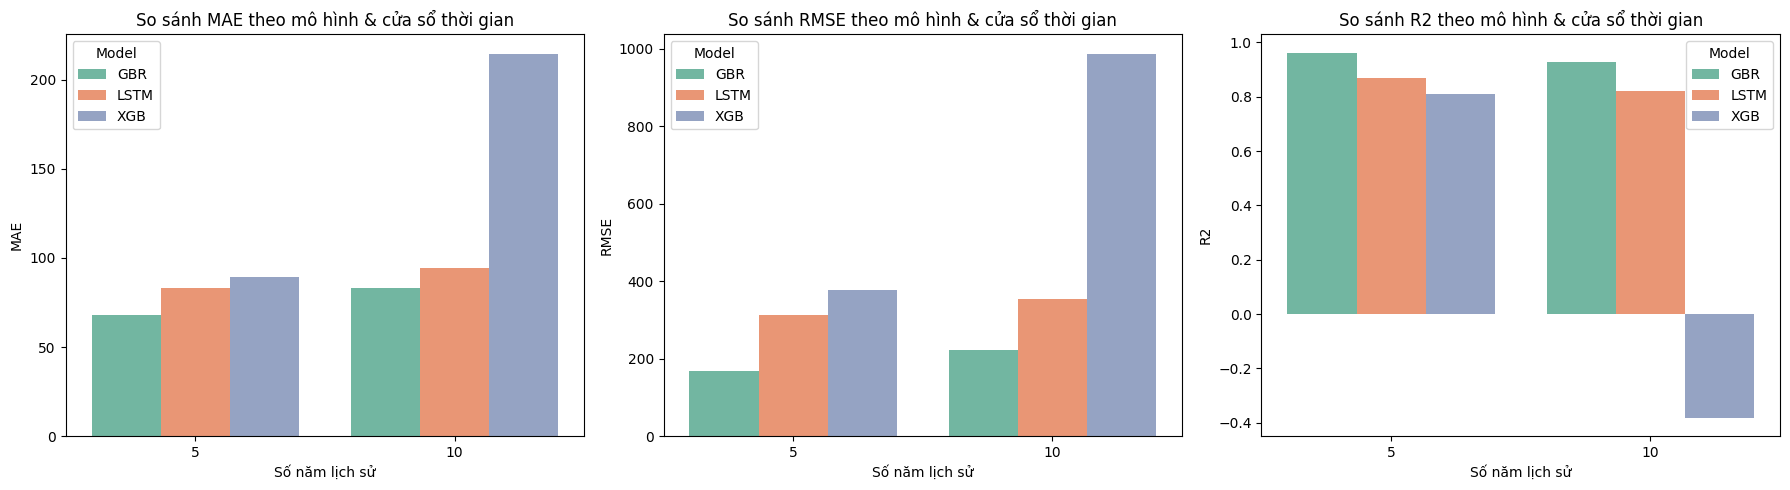


🏆 Top mô hình theo MAE:
  model  n_steps         MAE        RMSE        R2
0   GBR        5   68.082411  168.198338  0.962486
1  LSTM        5   82.961191  313.190531  0.869932
2   GBR       10   83.149568  222.771155  0.929637
3   XGB        5   89.313107  377.953449  0.810579
4  LSTM       10   94.191032  354.283428  0.822038
5   XGB       10  214.757509  987.190229 -0.381739

✅ Đã load model: GBR_win10


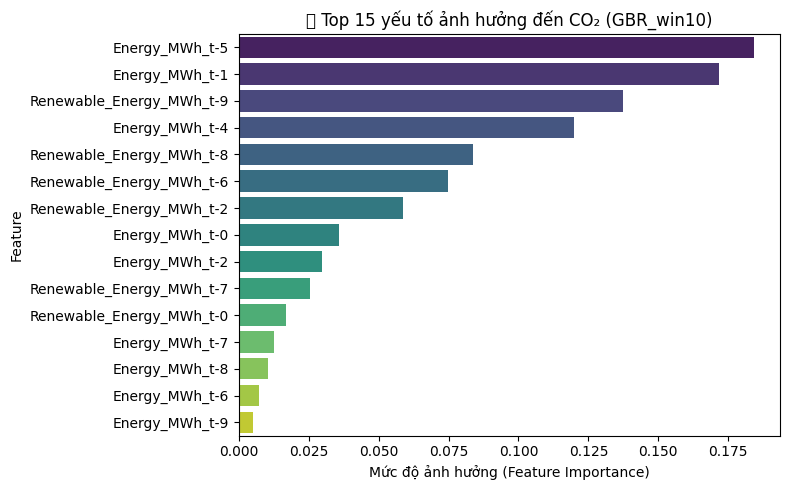


✅ Đã load model: XGB_win10


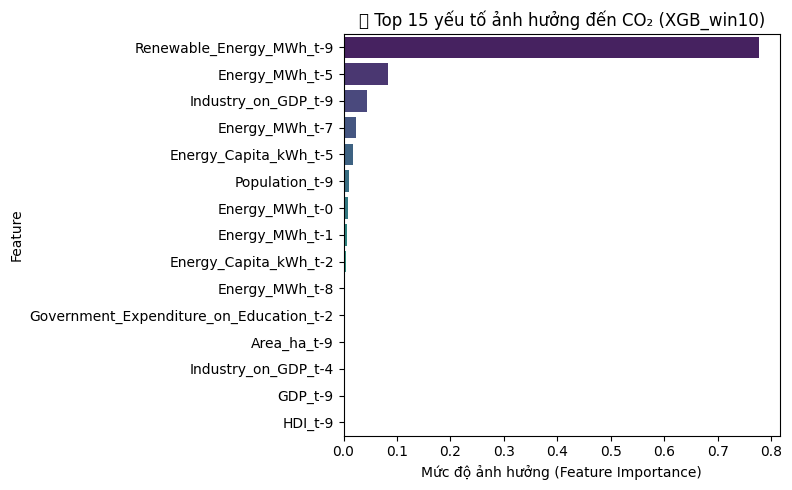


✅ Đã load model: GBR_win5


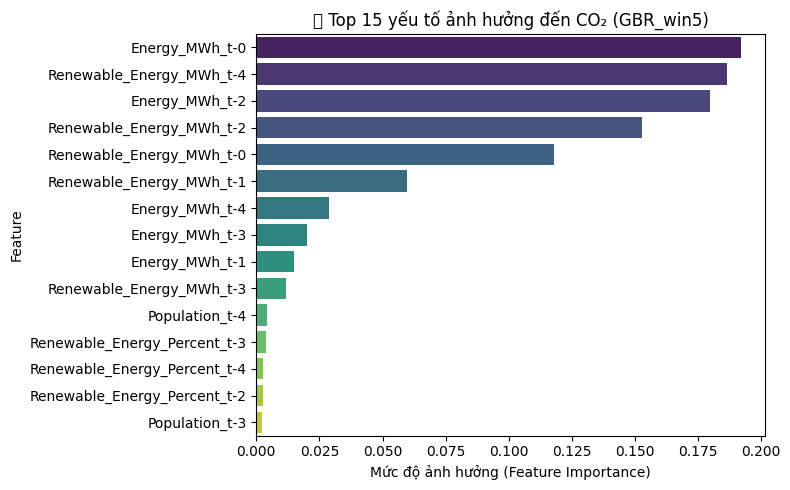


✅ Đã load model: XGB_win5


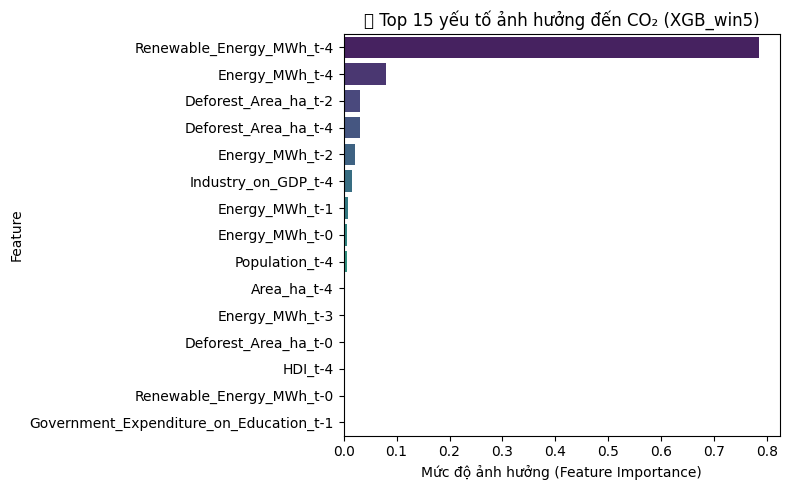


✅ Hoàn tất so sánh và hiển thị tất cả mô hình.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import numpy as np

# ==========================
# 1️⃣ Đọc file kết quả
# ==========================
path = "model_comparison_results.csv"
df_res = pd.read_csv(path)

# Giới hạn các model đã lưu bạn có
models_saved = ["GBR_win5", "XGB_win5", "LSTM_win5",
                "GBR_win10", "XGB_win10", "LSTM_win10"]

print("📊 Kết quả tổng hợp:")
print(df_res)

# ==========================
# 2️⃣ Biểu đồ so sánh MAE, RMSE, R²
# ==========================
metrics = ["MAE", "RMSE", "R2"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, m in enumerate(metrics):
    sns.barplot(ax=axes[i], data=df_res, x="n_steps", y=m, hue="model", palette="Set2")
    axes[i].set_title(f"So sánh {m} theo mô hình & cửa sổ thời gian")
    axes[i].set_xlabel("Số năm lịch sử")
    axes[i].set_ylabel(m)
    axes[i].legend(title="Model", loc="best")
plt.tight_layout()
plt.show()

# ==========================
# 3️⃣ In bảng xếp hạng mô hình
# ==========================
rank_mae = df_res.sort_values("MAE").reset_index(drop=True)
print("\n🏆 Top mô hình theo MAE:")
print(rank_mae[["model", "n_steps", "MAE", "RMSE", "R2"]])

# ==========================
# 4️⃣ Feature Importance cho XGBoost & GBR
# ==========================
dataset_path = "filled_dataset1.csv"
df = pd.read_csv(dataset_path)
feature_cols = [c for c in df.columns if c not in ["Country", "ISO_Code", "Year", "Co2_MtCO2", "Co2_Capita_tCO2"]]

for model_name in ["GBR_win10", "XGB_win10", "GBR_win5", "XGB_win5"]:
    model_path = f"{model_name}.pkl"
    if not os.path.exists(model_path):
        continue

    model = joblib.load(model_path)
    print(f"\n✅ Đã load model: {model_name}")
    if hasattr(model, "feature_importances_"):
        # Determine the window size from the model name
        n_steps = int(model_name.split('win')[1])
        # Create feature names for flattened data
        flattened_feature_names = [f"{col}_t-{i}" for i in range(n_steps-1, -1, -1) for col in feature_cols]

        importances = pd.Series(model.feature_importances_, index=flattened_feature_names)
        top_feats = importances.sort_values(ascending=False).head(15)
        plt.figure(figsize=(8, 5))
        sns.barplot(x=top_feats.values, y=top_feats.index, palette="viridis")
        plt.title(f"🌍 Top 15 yếu tố ảnh hưởng đến CO₂ ({model_name})")
        plt.xlabel("Mức độ ảnh hưởng (Feature Importance)")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠️ Model {model_name} không có thuộc tính feature_importances_ (có thể là LSTM).")

print("\n✅ Hoàn tất so sánh và hiển thị tất cả mô hình.")